# Exploring the extracted ROI timeseries



In [25]:
import numpy as np
import nibabel as nib
import glob
import matplotlib.pyplot as plt
from brainiak.eventseg import event
from scipy.stats import zscore
import matplotlib.patches as patches
import inspect

%autosave 5


Autosaving every 5 seconds


In [2]:
all_roi_timeseries = glob.glob('data/selected_ROI/*')
all_roi_timeseries

['data/selected_ROI/run1_temporal_pole.npy',
 'data/selected_ROI/run2_PMC.npy',
 'data/selected_ROI/run2_AG.npy',
 'data/selected_ROI/run3_PMC.npy',
 'data/selected_ROI/run1_mPFC.npy',
 'data/selected_ROI/run1_PMC.npy',
 'data/selected_ROI/run3_temporal_pole.npy',
 'data/selected_ROI/run2_temporal_pole.npy',
 'data/selected_ROI/run1_AG.npy',
 'data/selected_ROI/run3_AG.npy',
 'data/selected_ROI/run2_mPFC.npy',
 'data/selected_ROI/run3_mPFC.npy']

In [3]:
# sanity check that each timeseries has none zero 
# reformat data into a dictionary with subject and ROI keys, with timeseries as entries

all_data = {}

for f in all_roi_timeseries:
    
    idx = f.split('/')[-1]
    idx = idx[:-4]
    print(idx)
    
    data = np.load(f, allow_pickle = True)
    data = np.moveaxis(data, 2, 0)
    print(data.shape)
    
    # drop 0s, I think that the masks that we used picked up zeroed voxels AKA voxels outside of the actual brain space our data are in.
    non_zero_list = []
    for it in range(data.shape[0]):
        non_zero_list.append(data[it,:,:][~np.all(data[it,:,:] == 0, axis = 1)])
    
    non_zero_data = np.array(non_zero_list)
    print(non_zero_data.shape)
    
    all_data[idx] = non_zero_data
    
# voxels x TRs
# one row per subject per ROI

run1_temporal_pole
(17, 5517, 526)
(17, 4979, 526)
run2_PMC
(17, 8870, 452)
(17, 8870, 452)
run2_AG
(17, 4278, 452)
(17, 4230, 452)
run3_PMC
(17, 8870, 332)
(17, 8870, 332)
run1_mPFC
(17, 418, 526)
(17, 418, 526)
run1_PMC
(17, 8870, 526)
(17, 8870, 526)
run3_temporal_pole
(17, 5517, 332)
(17, 4979, 332)
run2_temporal_pole
(17, 5517, 452)
(17, 4979, 452)
run1_AG
(17, 4278, 526)
(17, 4230, 526)
run3_AG
(17, 4278, 332)
(17, 4230, 332)
run2_mPFC
(17, 418, 452)
(17, 418, 452)
run3_mPFC
(17, 418, 332)
(17, 418, 332)


In [4]:
data[1,:,:].shape

(418, 332)

### Plot carpet plot, activity over time for all voxels

(17, 4979, 526)
(4979, 526)
(17, 8870, 452)
(8870, 452)
(17, 4230, 452)
(4230, 452)
(17, 8870, 332)
(8870, 332)
(17, 418, 526)
(418, 526)
(17, 8870, 526)
(8870, 526)
(17, 4979, 332)
(4979, 332)
(17, 4979, 452)
(4979, 452)
(17, 4230, 526)
(4230, 526)
(17, 4230, 332)
(4230, 332)
(17, 418, 452)
(418, 452)
(17, 418, 332)
(418, 332)


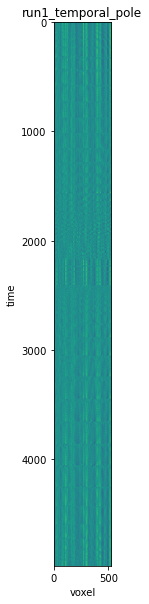

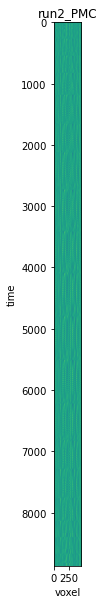

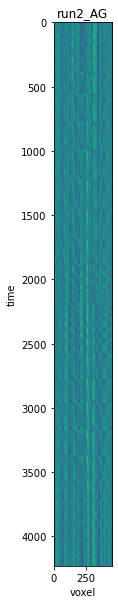

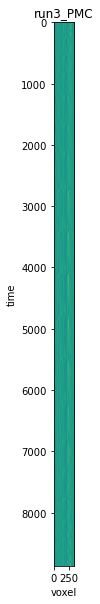

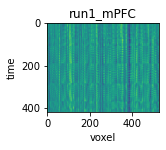

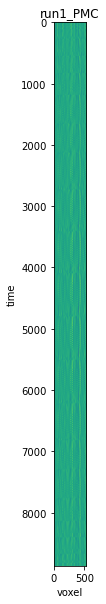

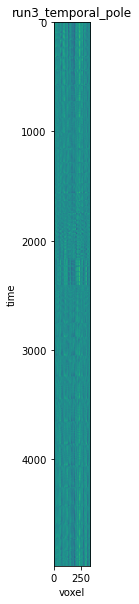

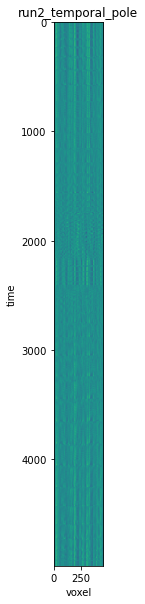

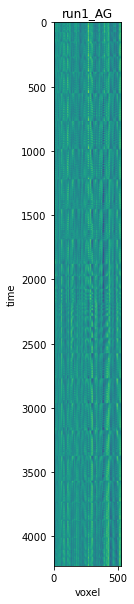

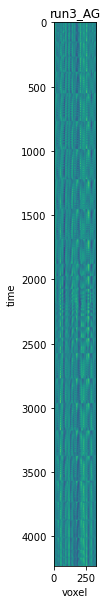

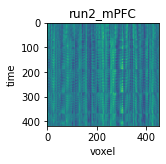

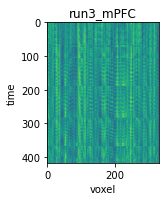

In [5]:
for it, s in enumerate(all_data):
    fig, ax = plt.subplots(figsize = (2,10))
    print(all_data[s].shape)
    meaned = all_data[s].mean(0)
    
    print(meaned.shape)

    #print(np.count_nonzero())
    ax.imshow(zscore(meaned, axis = 1))
    ax.set_title(s)
    ax.set_xlabel('voxel')
    ax.set_ylabel('time')

### Visualize correlation matrix for each ROI and run

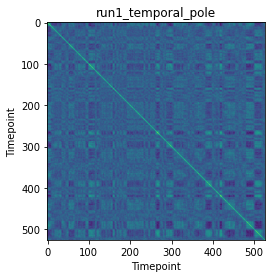

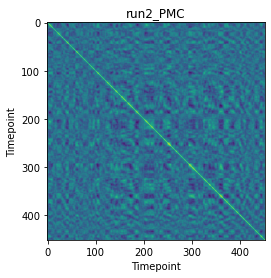

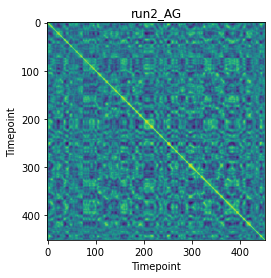

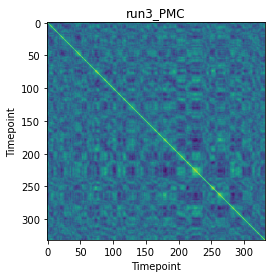

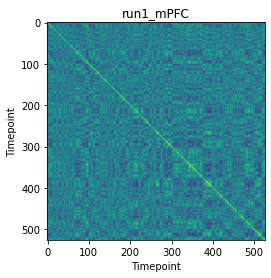

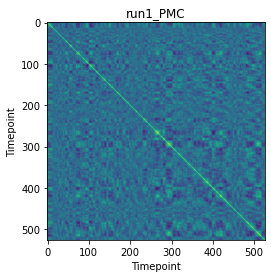

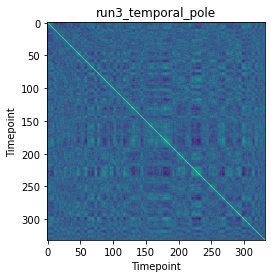

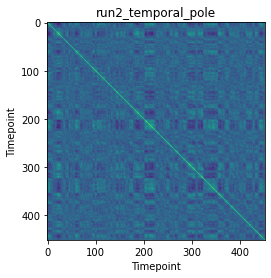

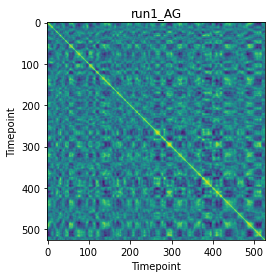

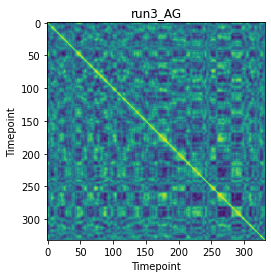

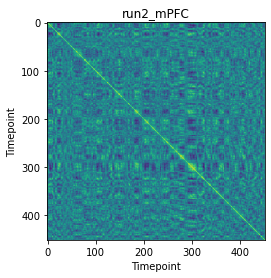

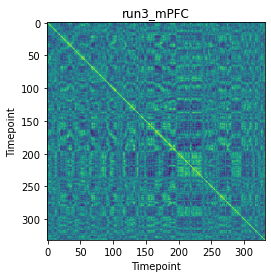

In [6]:
for it, s in enumerate(all_data):
    fig, ax = plt.subplots()
    meaned = all_data[s].mean(0)
    
    ax.imshow(np.corrcoef(zscore(meaned, axis = 1).T), cmap = 'viridis')
    ax.set_title(s)
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Timepoint')

# Visualizing the HMM for all ROIs
## create functions for iteration over all ROIs

In [7]:
# roi data in the form of subjects X voxels X TRs 

def run_hmm(roi_data):
    
    k_array = np.arange(2,50,5)
    test_ll = np.zeros(len(k_array))
    nsubj = roi_data.shape[0]
    print(nsubj)

    # note that the HMM takes a time x voxel ndarray. 

    # Loop over possible settings for the number of events k
    print('Trying events:', end=' ')
    for i, k in enumerate(k_array):
        print(k, end=' ')

        # Fit HMM to half of the subjects
        train = zscore(roi_data[:(nsubj//2),:,:].mean(0), axis=1).T
        HMM = event.EventSegment(k)
        HMM.fit(train)

        # Test log-likelihood (model fit) on other half of subjects
        test = zscore(roi_data[(nsubj//2):,:,:].mean(0), axis=1).T
        _, test_ll[i] = HMM.find_events(test)

    best_k = k_array[np.argmax(test_ll)]
    print('\nOptimal # of events: ', best_k)


    # Do a final fit with the optimal number of events, using all subjects
    # Set split_merge=True to prioritize fit quality over speed
    es = event.EventSegment(best_k, split_merge=True)
    es.fit(zscore(roi_data.mean(0), axis=1).T)
    return es

In [17]:
def plot_event_prob(da_list):
    for it in range(len(da_list)):
        plt.imshow(da_list[it][3].segments_[9].T, aspect='auto', interpolation='none', origin='lower')
        plt.colorbar(label='p(Event k at timepoint t)')
        plt.clim(0,0.6)
        plt.xlabel('Timepoint')
        plt.xticks(ticks=np.arange(0,T,50),
                   labels=[time.strftime('%M:%S', time.gmtime((b)*2)) for b in np.arange(T0,T0+T,50)])
        plt.ylabel('Event');
        plt.title(da_list[it][0])

In [8]:
def plot_correlation_w_boundaries(da_list):
    # list of lists, where inner entries are [roi, hmm_fitted]
    # Plot timepoint-timepoint correlation matrix
    
    # da list [0] = roi
    # da list [1] = roi_data
    # da list [2] = eb
        
    for it in range(len(da_list)):
        fig, ax = plt.subplots()
        ax.imshow(np.corrcoef(zscore(da_list[it][1].mean(0), axis=1).T), cmap = 'viridis')
        ax.set_title(da_list[it][0])
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Timepoint')

        # Plot boundaries as boxes on top of correlation matrix
        bounds_aug = np.concatenate(([0], da_list[it][2], [da_list[it][1].shape[1]]))
        for i in range(len(bounds_aug) - 1):
            rect = patches.Rectangle(
                (bounds_aug[i], bounds_aug[i]),
                bounds_aug[i+1] - bounds_aug[i],
                bounds_aug[i+1] - bounds_aug[i],
                linewidth = 2, edgecolor = 'w',facecolor = 'none'
            )
            ax.add_patch(rect)
        
        plt.savefig('figs/%s_corr_w_boundaries.jpg' % da_list[it][0], dpi = 200)
    

In [12]:
hmm_boundaries = []

for roi in all_data.keys():
    roi_data = all_data[roi]
    assert roi_data.shape[0] == 17
    
    try:
        hmm_fit = run_hmm(roi_data)

        eb = np.where(np.diff(np.argmax(hmm_fit.segments_[0],axis=1)))[0]
        hmm_boundaries.append([roi, roi_data, eb, hmm_fit]) 
        
    except:
        continue

17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  12
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  7
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  22
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  12
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  7
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  17
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  7
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  17
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  12
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  17
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  7
17
Trying events: 2 7 12 17 22 27 32 37 42 47 
Optimal # of events:  7


In [14]:
len(hmm_boundaries)

12

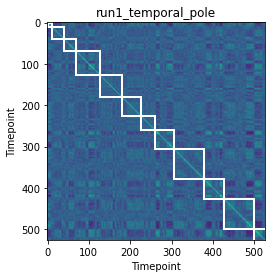

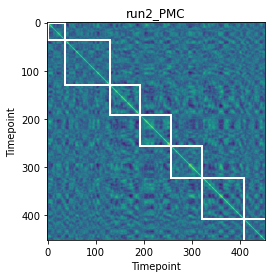

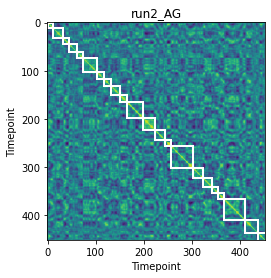

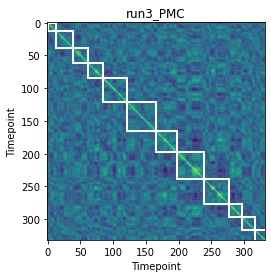

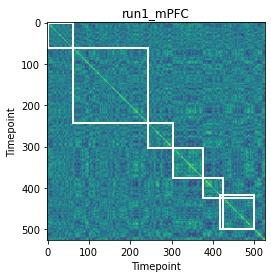

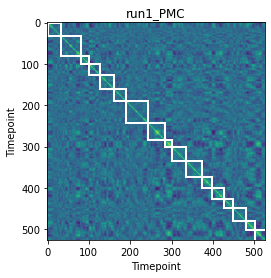

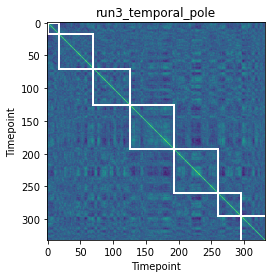

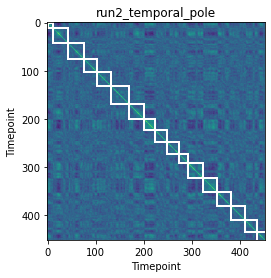

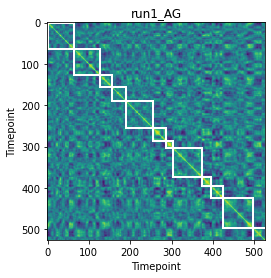

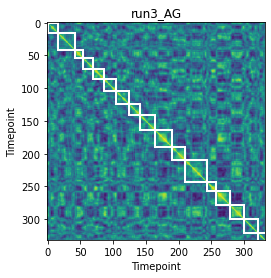

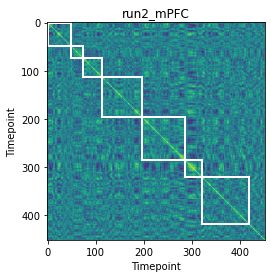

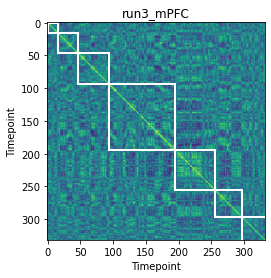

In [53]:
plot_correlation_w_boundaries(hmm_boundaries)

In [18]:
plot_event_prob(hmm_boundaries)

IndexError: list index out of range

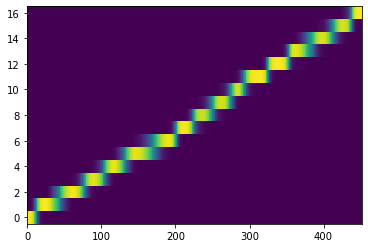

In [52]:
hmm_boundaries[0][3].segments_[0][13]

plt.imshow(hmm_boundaries[7][3].segments_[0].T, aspect='auto', interpolation='none', origin='lower')

In [26]:
inspect.getmembers(hmm_boundaries[0][3].segments_)

[('P',
  array([[0.97908745, 0.02091255, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.97908745, 0.02091255, 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.97908745, 0.02091255, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.97908745, 0.02091255,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.97908745,
          0.02091255, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 